In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from scipy.stats import ttest_rel, ttest_1samp, pearsonr

from analyze_study import aggregate_learning_curves, auc, ci95, summarize_bias

In [4]:
# See which study runs are available (just to check)
root = Path(sorted(glob("runs/study_*"))[-1])


print("Root:", root)
for alg in ["DDPG", "TD3"]:
    seed_dirs = sorted(root.glob(f"{alg}_seed*"))
    print(f"\n{alg} seed dirs found:", [d.name for d in seed_dirs] or "(none)")

    eval_files = list(root.glob(f"{alg}_seed*/{alg}_eval/evaluations.npz"))
    print(f"{alg} eval npz files:", [str(p.parent) for p in eval_files] or "(none)")

    # fallback: any nested evals (legacy names like DDPG_1/DDPG_eval)
    if not eval_files:
        any_evals = list(root.glob(f"**/{alg}_eval/evaluations.npz"))
        if any_evals:
            print(
                f"{alg} evals found via fallback search:",
                [str(p.parent) for p in any_evals],
            )
        else:
            print(f"{alg}: NO evaluations.npz found anywhere under {root}")

Root: runs/study_1760693288

DDPG seed dirs found: ['DDPG_seed0', 'DDPG_seed1', 'DDPG_seed2', 'DDPG_seed3', 'DDPG_seed4', 'DDPG_seed5', 'DDPG_seed6', 'DDPG_seed7', 'DDPG_seed8', 'DDPG_seed9']
DDPG eval npz files: ['runs/study_1760693288/DDPG_seed9/DDPG_eval', 'runs/study_1760693288/DDPG_seed0/DDPG_eval', 'runs/study_1760693288/DDPG_seed7/DDPG_eval', 'runs/study_1760693288/DDPG_seed6/DDPG_eval', 'runs/study_1760693288/DDPG_seed1/DDPG_eval', 'runs/study_1760693288/DDPG_seed8/DDPG_eval', 'runs/study_1760693288/DDPG_seed4/DDPG_eval', 'runs/study_1760693288/DDPG_seed3/DDPG_eval', 'runs/study_1760693288/DDPG_seed2/DDPG_eval', 'runs/study_1760693288/DDPG_seed5/DDPG_eval']

TD3 seed dirs found: ['TD3_seed0', 'TD3_seed1', 'TD3_seed2', 'TD3_seed3', 'TD3_seed4', 'TD3_seed5', 'TD3_seed6', 'TD3_seed7', 'TD3_seed8', 'TD3_seed9']
TD3 eval npz files: ['runs/study_1760693288/TD3_seed0/TD3_eval', 'runs/study_1760693288/TD3_seed7/TD3_eval', 'runs/study_1760693288/TD3_seed9/TD3_eval', 'runs/study_17606932

Analyzing: runs/study_1760693288
DDPG AUC: -778649.4 ± 0.0, Final: -45.4 ± 0.0
TD3 AUC: -1346128.1 ± 0.0, Final: -109.1 ± 0.0
Paired t-test AUC TD3>DDPG: t=-inf, p=0
Paired t-test FINAL TD3>DDPG: t=-26917299632287640.00, p=6.86e-145
DDPG bias: mean=55.21 (n=10), one-sample t p=0.0
TD3  bias: mean=28.19 (n=10), one-sample t p=0.0
Paired t-test TD3 vs DDPG bias: p=0.0
DDPG AUC: -778649.4 ± 0.0, Final: -45.4 ± 0.0
TD3 AUC: -1346128.1 ± 0.0, Final: -109.1 ± 0.0
Paired t-test AUC TD3>DDPG: t=-inf, p=0
Paired t-test FINAL TD3>DDPG: t=-26917299632287640.00, p=6.86e-145
DDPG bias: mean=55.21 (n=10), one-sample t p=0
TD3  bias: mean=28.19 (n=10), one-sample t p=0
Paired t-test TD3 vs DDPG bias: p=0
corr(bias, return) DDPG: r=nan, p=nan
corr(bias, return) TD3 : r=nan, p=nan


/Users/bw/Desktop/Dev/SU/IAR/mini-projet-iar/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:423: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)
/Users/bw/Desktop/Dev/SU/IAR/mini-projet-iar/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/4d/16h1rbzx3z7bz77nfjwvcxkw0000gn/T/ipykernel_42063/1777819432.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ddpg_b, td3_b], labels=["DDPG bias", "TD3 min(Q) bias"])
/Users/bw/Desktop

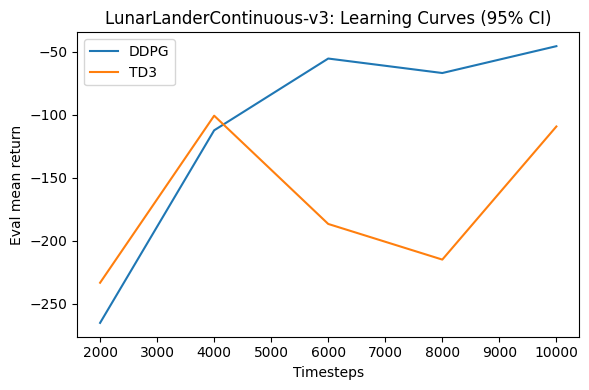

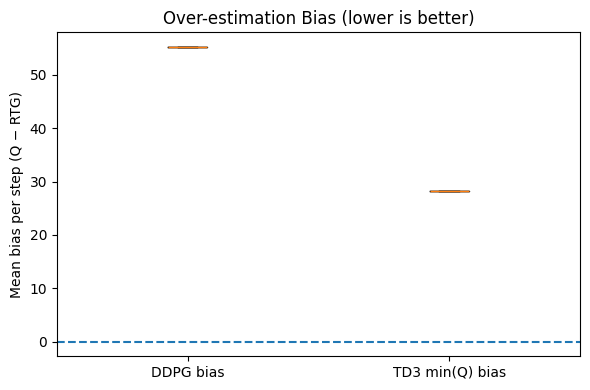

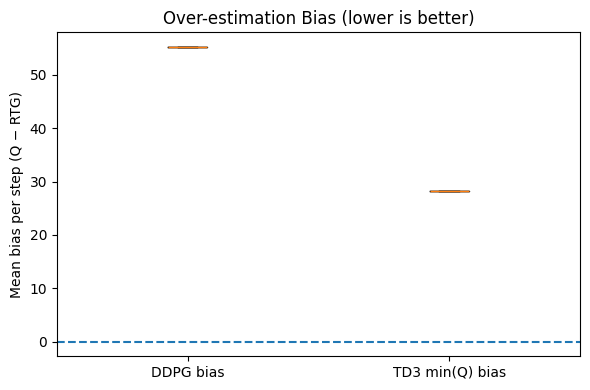

In [5]:
root = Path(sorted(glob("runs/study_*"))[-1])
print("Analyzing:", root)

# Learning curves
alg2 = aggregate_learning_curves(root)

# Plot whatever exists

plt.figure(figsize=(6, 4))
for alg in alg2:
    ts, mat = alg2[alg]
    mean = mat.mean(axis=0)
    lo = np.percentile(mat, 2.5, axis=0) if mat.shape[0] > 1 else mean
    hi = np.percentile(mat, 97.5, axis=0) if mat.shape[0] > 1 else mean
    plt.plot(ts, mean, label=alg)
    plt.fill_between(ts, lo, hi, alpha=0.2)
plt.xlabel("Timesteps")
plt.ylabel("Eval mean return")
plt.title("LunarLanderContinuous-v3: Learning Curves (95% CI)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_learning_curves.png", dpi=200)

# Stats only if both algos are present
if all(a in alg2 for a in ["DDPG", "TD3"]):
    stats = {}

    for alg, (ts, mat) in alg2.items():
        aucs = np.array([auc(ts, m) for m in mat])
        finals = mat[:, -1]
        stats[alg] = {"AUC": aucs, "FINAL": finals}
        m_auc, ci_auc = ci95(aucs)
        m_fin, ci_fin = ci95(finals)
        print(
            f"{alg} AUC: {m_auc:.1f} ± {ci_auc:.1f}, Final: {m_fin:.1f} ± {ci_fin:.1f}"
        )

    k = min(len(stats["DDPG"]["AUC"]), len(stats["TD3"]["AUC"]))
    if k >= 2:  # need >=2 paired samples for a meaningful t-test
        ddpg_auc = stats["DDPG"]["AUC"][:k]
        td3_auc = stats["TD3"]["AUC"][:k]
        ddpg_fin = stats["DDPG"]["FINAL"][:k]
        td3_fin = stats["TD3"]["FINAL"][:k]
        t_auc = ttest_rel(td3_auc, ddpg_auc)
        t_fin = ttest_rel(td3_fin, ddpg_fin)
        print(
            f"Paired t-test AUC TD3>DDPG: t={t_auc.statistic:.2f}, p={t_auc.pvalue:.3g}"
        )
        print(
            f"Paired t-test FINAL TD3>DDPG: t={t_fin.statistic:.2f}, p={t_fin.pvalue:.3g}"
        )
    else:
        print("Not enough paired seeds for t-tests (need k ≥ 2).")

    # Bias plots only if result.json exist
    ddpg_b, td3_b = summarize_bias(root)
    if ddpg_b.size and td3_b.size:
        t_ddpg = ttest_1samp(ddpg_b, popmean=0.0) if ddpg_b.size >= 2 else None
        t_td3 = ttest_1samp(td3_b, popmean=0.0) if td3_b.size >= 2 else None

        k_b = min(ddpg_b.size, td3_b.size)
        t_pair = ttest_rel(td3_b[:k_b], ddpg_b[:k_b]) if k_b >= 2 else None

        plt.figure(figsize=(6, 4))
        plt.boxplot([ddpg_b, td3_b], labels=["DDPG bias", "TD3 min(Q) bias"])
        plt.axhline(0, linestyle="--")
        plt.ylabel("Mean bias per step (Q − RTG)")
        plt.title("Over-estimation Bias (lower is better)")
        plt.tight_layout()
        plt.savefig("fig_bias_box.png", dpi=200)

        print(
            f"DDPG bias: mean={ddpg_b.mean():.2f} (n={len(ddpg_b)}), one-sample t p={getattr(t_ddpg,'pvalue','NA')}"
        )
        print(
            f"TD3  bias: mean={td3_b.mean():.2f} (n={len(td3_b)}), one-sample t p={getattr(t_td3,'pvalue','NA')}"
        )
        print(f"Paired t-test TD3 vs DDPG bias: p={getattr(t_pair,'pvalue','NA')}")
    else:
        print("No bias JSONs found; did you save result.json in each seed dir?")
else:
    print("Only one algorithm had eval data; skipping paired stats.")


# AUC & final performance tests
stats = {}
for alg, (ts, mat) in alg2.items():
    aucs = [auc(ts, m) for m in mat]
    finals = mat[:, -1]
    stats[alg] = {"AUC": np.array(aucs), "FINAL": np.array(finals)}
    m_auc, ci_auc = ci95(aucs)
    m_fin, ci_fin = ci95(finals)
    print(f"{alg} AUC: {m_auc:.1f} ± {ci_auc:.1f}, Final: {m_fin:.1f} ± {ci_fin:.1f}")

# Paired tests across seeds (align by number of seeds present)
k = min(len(stats["DDPG"]["AUC"]), len(stats["TD3"]["AUC"]))
ddpg_auc = stats["DDPG"]["AUC"][:k]
td3_auc = stats["TD3"]["AUC"][:k]
ddpg_fin = stats["DDPG"]["FINAL"][:k]
td3_fin = stats["TD3"]["FINAL"][:k]

t_auc = ttest_rel(td3_auc, ddpg_auc)
t_fin = ttest_rel(td3_fin, ddpg_fin)
print(f"Paired t-test AUC TD3>DDPG: t={t_auc.statistic:.2f}, p={t_auc.pvalue:.3g}")
print(f"Paired t-test FINAL TD3>DDPG: t={t_fin.statistic:.2f}, p={t_fin.pvalue:.3g}")

# Over-estimation bias
ddpg_b, td3_b = summarize_bias(root)
t_ddpg = ttest_1samp(ddpg_b, popmean=0.0)
t_td3 = ttest_1samp(td3_b, popmean=0.0)
t_pair = ttest_rel(td3_b[:k], ddpg_b[:k])

plt.figure(figsize=(6, 4))
plt.boxplot([ddpg_b, td3_b], labels=["DDPG bias", "TD3 min(Q) bias"])
plt.axhline(0, linestyle="--")
plt.ylabel("Mean bias per step (Q − RTG)")
plt.title("Over-estimation Bias (lower is better)")
plt.tight_layout()
plt.savefig("fig_bias_box.png", dpi=200)

print(
    f"DDPG bias: mean={ddpg_b.mean():.2f} (n={len(ddpg_b)}), one-sample t p={t_ddpg.pvalue:.3g}"
)
print(
    f"TD3  bias: mean={td3_b.mean():.2f} (n={len(td3_b)}), one-sample t p={t_td3.pvalue:.3g}"
)
print(f"Paired t-test TD3 vs DDPG bias: p={t_pair.pvalue:.3g}")

ddpg_ret = stats["DDPG"]["FINAL"][:k]
td3_ret = stats["TD3"]["FINAL"][:k]
r_ddpg = pearsonr(ddpg_b[:k], ddpg_ret)
r_td3 = pearsonr(td3_b[:k], td3_ret)
print(f"corr(bias, return) DDPG: r={r_ddpg.statistic:.2f}, p={r_ddpg.pvalue:.3g}")
print(f"corr(bias, return) TD3 : r={r_td3.statistic:.2f}, p={r_td3.pvalue:.3g}")